### Search for optimal amp and time for RST

In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [2]:
best_seq = np.load("../pulse_detuning/top1_sequence.npy")

Raman pulses: 100%|██████████| 260/260 [00:16<00:00, 16.02it/s]


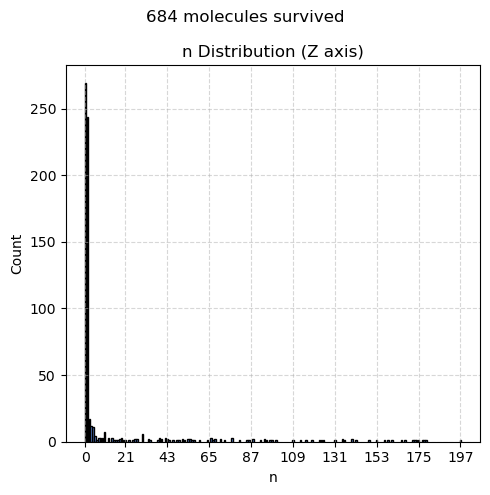

------SLM molecules------
survival rate:  0.684
N_z bar:  12.769
Ground state rate:  0.336


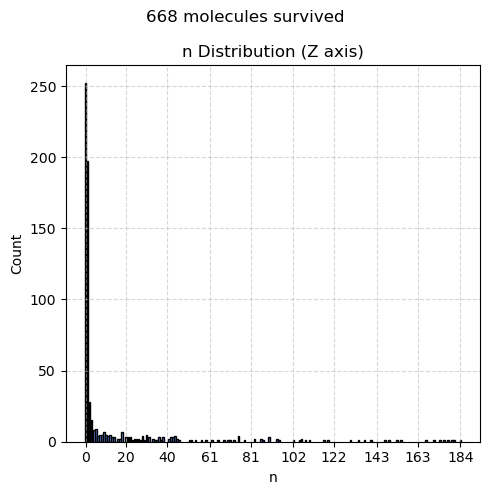

------AOD molecules------
survival rate:  0.668
N_z bar:  12.346
Ground state rate:  0.287


In [3]:
temp = [25e-6, 25e-6, 25e-6]
mol_SLM = cr.build_thermal_molecules(1000, temp)
mol_AOD = cr.build_thermal_molecules(
    1000, 
    temp, 
    trap_detuning_mean=-2e3,
    trap_detuning_sigma=0.0,
    carrier_detuning_mean=3e3,
    carrier_detuning_sigma=0.0,)

cr.raman_cool_with_pumping(mol_SLM, best_seq, res, show_progress=True)
cr.raman_cool_with_pumping(mol_AOD, best_seq, res, show_progress=True)

dist = cr.get_n_distribution_gpu(mol_SLM, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_SLM)
print("------SLM molecules------")
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))

dist = cr.get_n_distribution_gpu(mol_AOD, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_AOD)
print("------AOD molecules------")
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))


RST grid scan + fit: 100%|██████████| 81/81 [08:59<00:00,  6.67s/it]


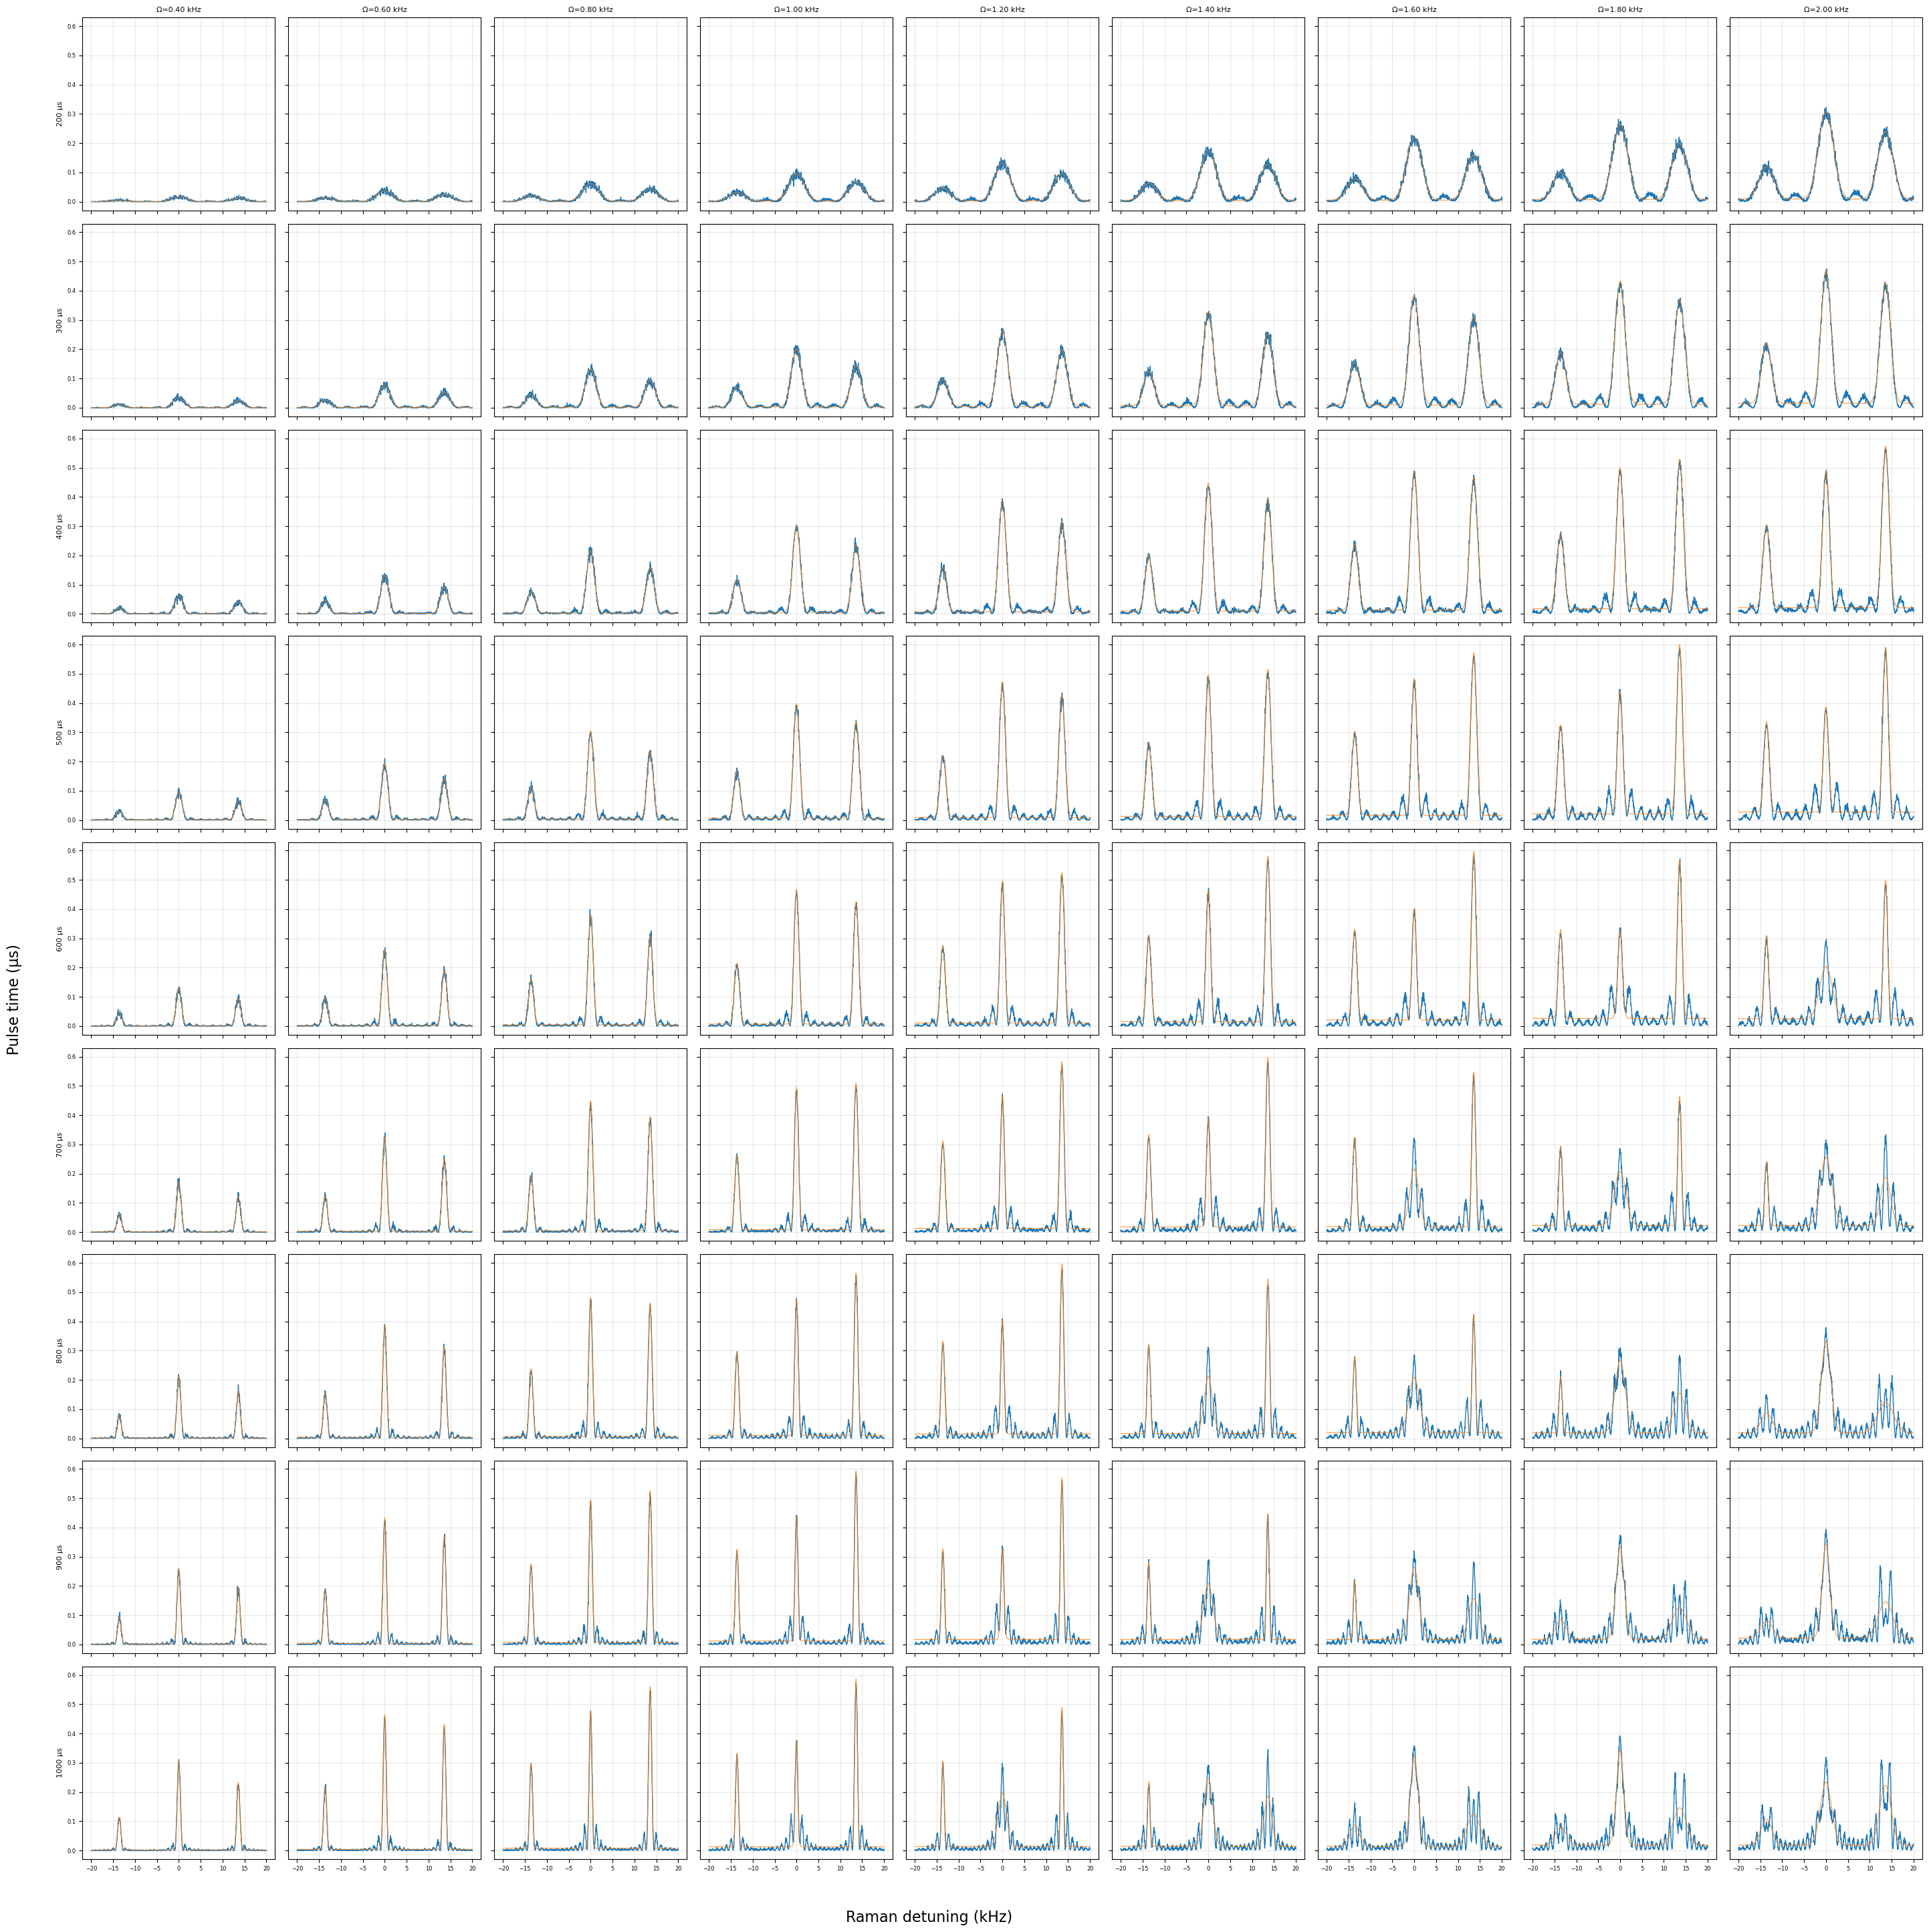

In [15]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

# ----------------------------
# Model: 3 Gaussians + baseline
# ----------------------------
def g3(x, A1, x1, s1, A2, x2, s2, A3, x3, s3, c0):
    return (
        A1 * np.exp(-0.5 * ((x - x1) / s1) ** 2) +
        A2 * np.exp(-0.5 * ((x - x2) / s2) ** 2) +
        A3 * np.exp(-0.5 * ((x - x3) / s3) ** 2) +
        c0
    )

def nearest_y(x, y, x0):
    idx = int(np.argmin(np.abs(x - x0)))
    return y[idx]

# Frequency scan (keep fixed)
zt_freqs = cp.linspace(-20e3, 20e3, 1000)

# Parameter grids
num = 9
rabi_vals  = np.linspace(0.4e3, 2e3, num)        # Hz
pulse_vals = np.linspace(200e-6, 1000e-6, num)   # seconds

fig, axes = plt.subplots(num, num, figsize=(30, 30), sharex=True, sharey=True)

# Store fitted amplitude ratio A(-12)/A(+12)
ratio_map = np.full((num, num), np.nan, dtype=float)

total_runs = len(rabi_vals) * len(pulse_vals)

with tqdm(total=total_runs, desc="RST grid scan + fit") as pbar:
    for i, pulse in enumerate(pulse_vals):
        for j, rabi in enumerate(rabi_vals):

            ax = axes[i, j]

            # --- Run thermometry ---
            freqs, pol = cr.raman_sideband_thermometry(
                molecules_dev=mol_SLM,
                axis=2,
                frequencys=zt_freqs,
                rabi_freq=rabi,
                pulse_time=pulse,
                res=res,
                k_max=2,
                show_progress=False
            )

            # Move to CPU (kHz for x, "fraction" for y)
            x = cp.asnumpy(freqs) * 1e-3          # kHz
            y = cp.asnumpy(pol) / 1000.0          # your plotted units

            ax.plot(x, y, linewidth=1)

            # ----------------------------
            # Fit 3 peaks: centers ~ (-12, 0, +12) kHz
            # ----------------------------
            # Initial guesses from data near the peaks
            c0_guess = float(np.min(y))
            A1_guess = float(max(nearest_y(x, y, -12.0) - c0_guess, 1e-6))
            A2_guess = float(max(nearest_y(x, y,   0.0) - c0_guess, 1e-6))
            A3_guess = float(max(nearest_y(x, y, +12.0) - c0_guess, 1e-6))
            s_guess = 1.0  # kHz (reasonable starting width; adjust if needed)

            p0 = [A1_guess, -13.6, s_guess,
                  A2_guess,   0.0, s_guess,
                  A3_guess, +13.6, s_guess,
                  c0_guess]

            # Bounds: keep centers near guesses, widths positive, baseline free-ish
            lb = [0.0,  -16.0, 0.1,
                  0.0,   -4.0, 0.1,
                  0.0,   +8.0, 0.1,
                  -np.inf]
            ub = [np.inf,  -8.0, 10.0,
                  np.inf,  +4.0, 10.0,
                  np.inf, +16.0, 10.0,
                  np.inf]

            try:
                popt, _ = curve_fit(
                    g3, x, y, p0=p0, bounds=(lb, ub),
                    maxfev=20000
                )

                # Extract amplitudes for -12 and +12 peaks
                A_red  = popt[0]   # A1 at ~ -12 kHz
                A_blue = popt[6]   # A3 at ~ +12 kHz

                # Ratio (cooling/heating). Avoid division by ~0.
                if A_blue > 0:
                    ratio_map[i, j] = A_blue / A_red

                # Optional: overlay fitted curve (thin)
                yfit = g3(x, *popt)
                ax.plot(x, yfit, linewidth=0.8, alpha=0.8)

            except Exception:
                # Leave ratio_map as NaN if fit fails
                pass

            # Titles / labels
            if i == 0:
                ax.set_title(f"Ω={rabi/1e3:.2f} kHz", fontsize=8)
            if j == 0:
                ax.set_ylabel(f"{pulse*1e6:.0f} µs", fontsize=8)

            ax.tick_params(labelsize=6)
            ax.grid(alpha=0.3)

            pbar.update(1)

# Global labels for grid
fig.text(0.5, 0.04, "Raman detuning (kHz)", ha="center", fontsize=16)
fig.text(0.04, 0.5, "Pulse time (µs)", va="center", rotation="vertical", fontsize=16)
plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()

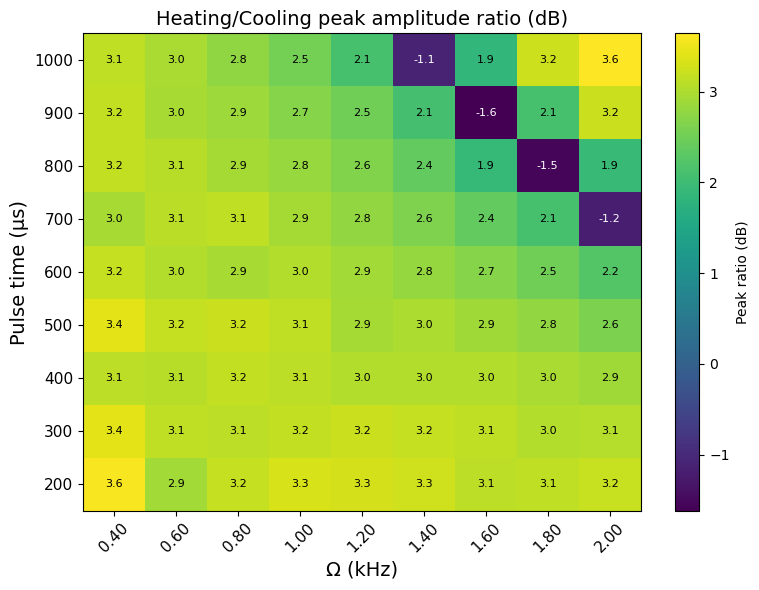

In [16]:
# ----------------------------
# Heatmap of amplitude ratio (dB)
# ----------------------------
plt.figure(figsize=(8, 6))

# Convert ratio to dB
ratio_db = 10.0 * np.log10(np.clip(ratio_map, 1e-300, np.inf))

im = plt.imshow(
    ratio_db,
    origin="lower",
    aspect="auto",
    interpolation="nearest"
)

cbar = plt.colorbar(im)
cbar.set_label("Peak ratio (dB)")

# --- Center ticks on pixels ---
plt.xticks(
    ticks=np.arange(num),
    labels=[f"{v/1e3:.2f}" for v in rabi_vals],
    rotation=45
)
plt.yticks(
    ticks=np.arange(num),
    labels=[f"{v*1e6:.0f}" for v in pulse_vals]
)

plt.xlabel("Ω (kHz)", fontsize=14)
plt.ylabel("Pulse time (µs)", fontsize=14)
plt.title("Heating/Cooling peak amplitude ratio (dB)", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=11)

# --- Write value on each pixel ---
for i in range(num):
    for j in range(num):
        val = ratio_db[i, j]
        if np.isfinite(val):
            plt.text(
                j, i,
                f"{val:.1f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if val < np.nanmax(ratio_db)*0.5 else "black"
            )

plt.tight_layout()
plt.show()

RST grid scan + fit: 100%|██████████| 30/30 [03:18<00:00,  6.61s/it]


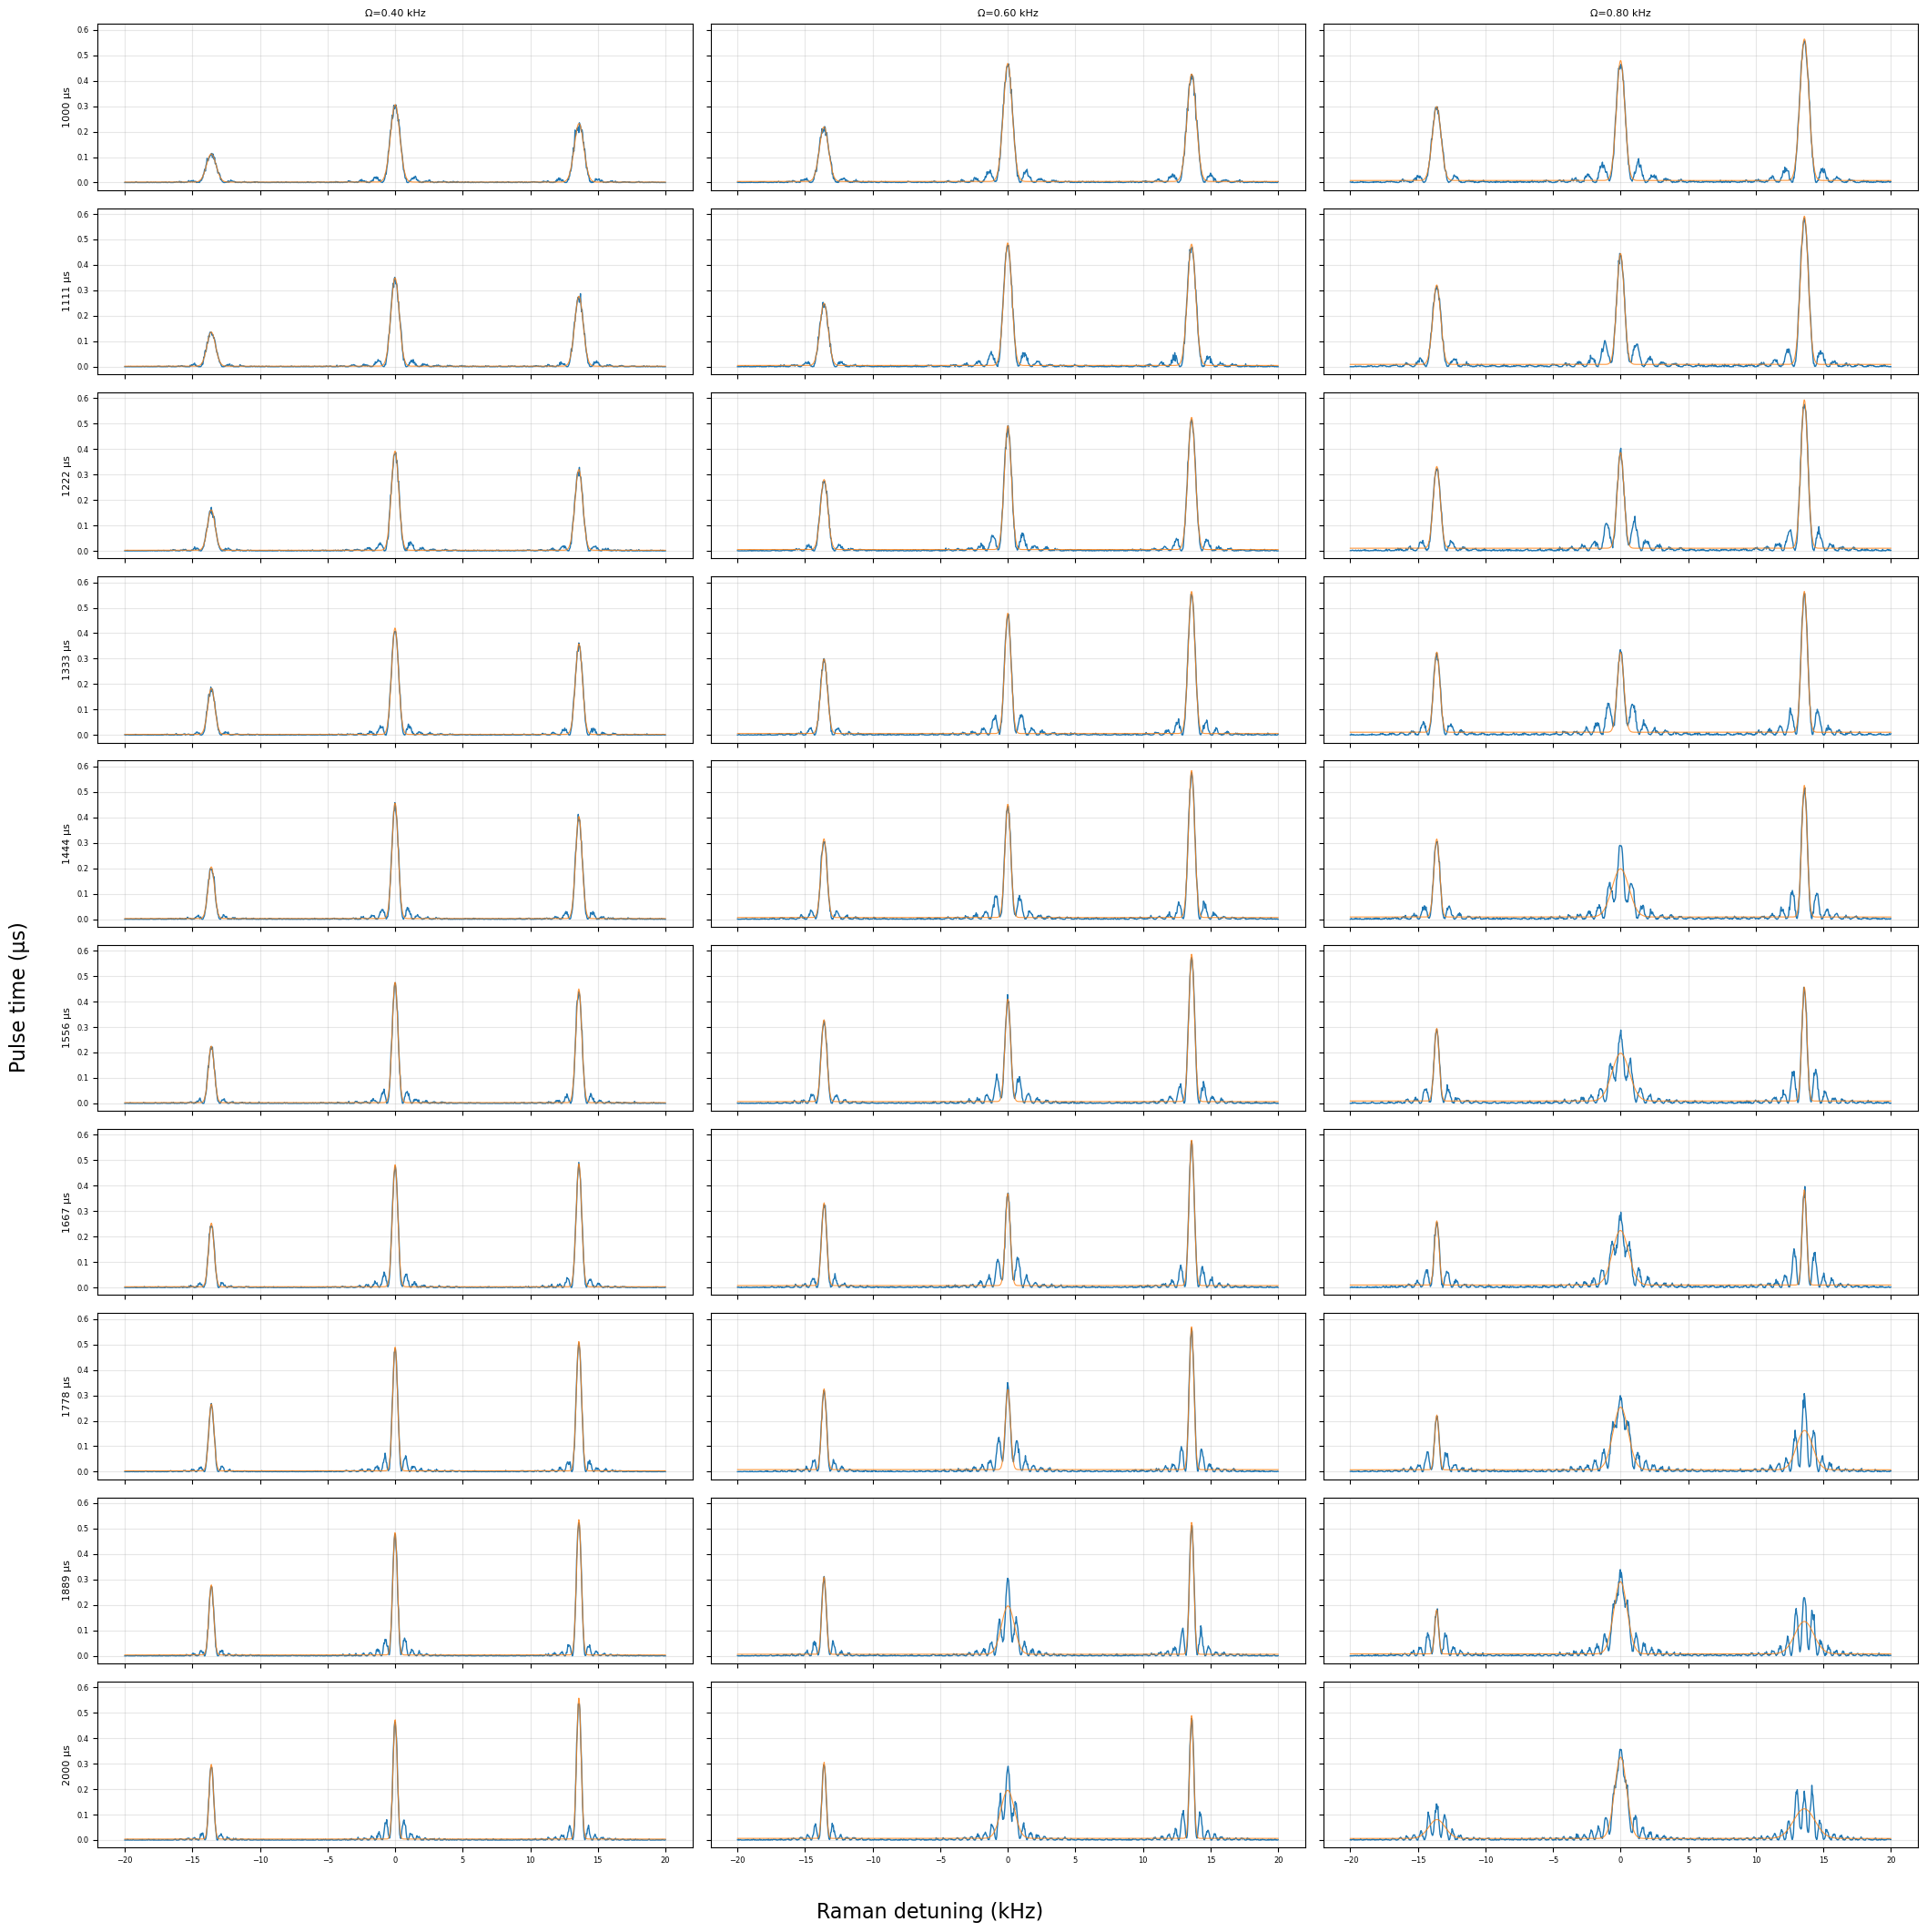

In [30]:
# Frequency scan (keep fixed)
zt_freqs = cp.linspace(-20e3, 20e3, 1000)

# Parameter grids
rabi_vals  = np.linspace(0.4e3, 0.8e3, 3)        # Hz
pulse_vals = np.linspace(1000e-6, 2000e-6, 10)   # seconds

fig, axes = plt.subplots(len(pulse_vals), len(rabi_vals), figsize=(22, 22), sharex=True, sharey=True)

# Store fitted amplitude ratio A(-12)/A(+12)
ratio_map = np.full((len(pulse_vals), len(rabi_vals)), np.nan, dtype=float)

total_runs = len(rabi_vals) * len(pulse_vals)

with tqdm(total=total_runs, desc="RST grid scan + fit") as pbar:
    for i, pulse in enumerate(pulse_vals):
        for j, rabi in enumerate(rabi_vals):

            ax = axes[i, j]

            # --- Run thermometry ---
            freqs, pol = cr.raman_sideband_thermometry(
                molecules_dev=mol_SLM,
                axis=2,
                frequencys=zt_freqs,
                rabi_freq=rabi,
                pulse_time=pulse,
                res=res,
                k_max=2,
                show_progress=False
            )

            # Move to CPU (kHz for x, "fraction" for y)
            x = cp.asnumpy(freqs) * 1e-3          # kHz
            y = cp.asnumpy(pol) / 1000.0          # your plotted units

            ax.plot(x, y, linewidth=1)

            # ----------------------------
            # Fit 3 peaks: centers ~ (-12, 0, +12) kHz
            # ----------------------------
            # Initial guesses from data near the peaks
            c0_guess = float(np.min(y))
            A1_guess = float(max(nearest_y(x, y, -12.0) - c0_guess, 1e-6))
            A2_guess = float(max(nearest_y(x, y,   0.0) - c0_guess, 1e-6))
            A3_guess = float(max(nearest_y(x, y, +12.0) - c0_guess, 1e-6))
            s_guess = 1.0  # kHz (reasonable starting width; adjust if needed)

            p0 = [A1_guess, -13.6, s_guess,
                  A2_guess,   0.0, s_guess,
                  A3_guess, +13.6, s_guess,
                  c0_guess]

            # Bounds: keep centers near guesses, widths positive, baseline free-ish
            lb = [0.0,  -16.0, 0.1,
                  0.0,   -4.0, 0.1,
                  0.0,   +8.0, 0.1,
                  -np.inf]
            ub = [np.inf,  -8.0, 10.0,
                  np.inf,  +4.0, 10.0,
                  np.inf, +16.0, 10.0,
                  np.inf]

            try:
                popt, _ = curve_fit(
                    g3, x, y, p0=p0, bounds=(lb, ub),
                    maxfev=20000
                )

                # Extract amplitudes for -12 and +12 peaks
                A_red  = popt[0]   # A1 at ~ -12 kHz
                A_blue = popt[6]   # A3 at ~ +12 kHz

                # Ratio (cooling/heating). Avoid division by ~0.
                if A_blue > 0:
                    ratio_map[i, j] = A_blue / A_red

                # Optional: overlay fitted curve (thin)
                yfit = g3(x, *popt)
                ax.plot(x, yfit, linewidth=0.8, alpha=0.8)

            except Exception:
                # Leave ratio_map as NaN if fit fails
                pass

            # Titles / labels
            if i == 0:
                ax.set_title(f"Ω={rabi/1e3:.2f} kHz", fontsize=8)
            if j == 0:
                ax.set_ylabel(f"{pulse*1e6:.0f} µs", fontsize=8)

            ax.tick_params(labelsize=6)
            ax.grid(alpha=0.3)

            pbar.update(1)

# Global labels for grid
fig.text(0.5, 0.04, "Raman detuning (kHz)", ha="center", fontsize=16)
fig.text(0.04, 0.5, "Pulse time (µs)", va="center", rotation="vertical", fontsize=16)
plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()

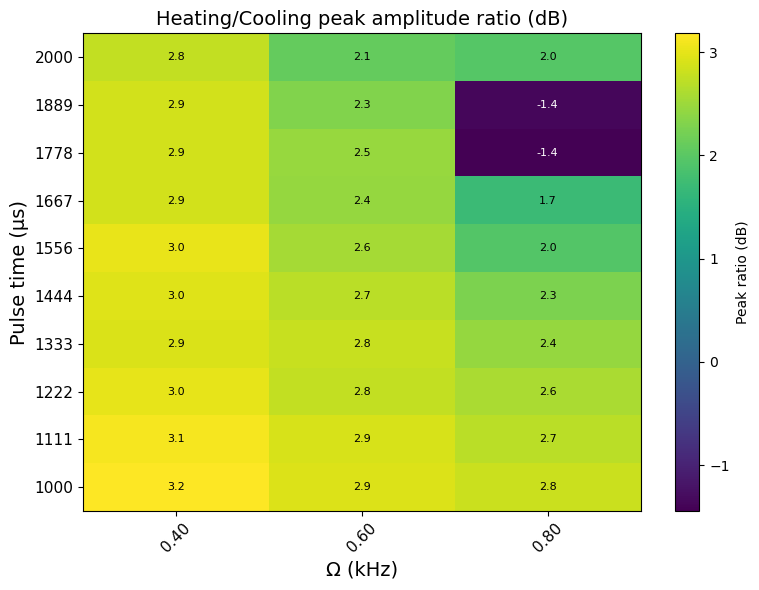

In [31]:
# ----------------------------
# Heatmap of amplitude ratio (dB)
# ----------------------------
plt.figure(figsize=(8, 6))

# Convert ratio to dB
ratio_db = 10.0 * np.log10(np.clip(ratio_map, 1e-300, np.inf))

im = plt.imshow(
    ratio_db,
    origin="lower",
    aspect="auto",
    interpolation="nearest"
)

cbar = plt.colorbar(im)
cbar.set_label("Peak ratio (dB)")

# --- Center ticks on pixels ---
plt.xticks(
    ticks=np.arange(len(rabi_vals)),
    labels=[f"{v/1e3:.2f}" for v in rabi_vals],
    rotation=45
)
plt.yticks(
    ticks=np.arange(len(pulse_vals)),
    labels=[f"{v*1e6:.0f}" for v in pulse_vals]
)

plt.xlabel("Ω (kHz)", fontsize=14)
plt.ylabel("Pulse time (µs)", fontsize=14)
plt.title("Heating/Cooling peak amplitude ratio (dB)", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=11)

# --- Write value on each pixel ---
for i, _ in enumerate(pulse_vals):
    for j, _ in enumerate(rabi_vals):
        val = ratio_db[i, j]
        if np.isfinite(val):
            plt.text(
                j, i,
                f"{val:.1f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if val < np.nanmax(ratio_db)*0.5 else "black"
            )

plt.tight_layout()
plt.show()